<a href="https://colab.research.google.com/github/hiteshisawariya485/Signature_Verification/blob/main/VGG16(TL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python

In [ ]:
!pip install tensorflow

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/DATASET'


In [ ]:
# Load and preprocess images to RGB
def load_data(image_size=(224, 224)):
    X, y = [], []
    for label, folder in enumerate(['full_forg', 'full_org']):
        folder_path = os.path.join(DATA_PATH, folder)
        for file in os.listdir(folder_path):
            path = os.path.join(folder_path, file)
            img = cv2.imread(path)  # RGB
            if img is None:
                continue
            img = cv2.resize(img, image_size)
            img = img / 255.0
            X.append(img)
            y.append(label)
    return np.array(X), to_categorical(np.array(y), num_classes=2)

# Load and split data
X, y = load_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [ ]:
#Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
train_gen = datagen.flow(X_train, y_train, batch_size=32)
val_gen = datagen.flow(X_val, y_val, batch_size=32)


In [ ]:
# Load VGG16 without top
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
#Add custom top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)


In [ ]:
#Compile
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#Early Stopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

In [ ]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stop, lr_reduce]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 64s 744ms/step - accuracy: 0.5041 - loss: 0.7763 - val_accuracy: 0.6425 - val_loss: 0.6728 - learning_rate: 1.0000e-04
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 538ms/step - accuracy: 0.5378 - loss: 0.7250 - val_accuracy: 0.6667 - val_loss: 0.6591 - learning_rate: 1.0000e-04
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 39s 573ms/step - accuracy: 0.5733 - loss: 0.6817 - val_accuracy: 0.5493 - val_loss: 0.6683 - learning_rate: 1.0000e-04
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 39s 575ms/step - accuracy: 0.5647 - loss: 0.6884 - val_accuracy: 0.6574 - val_loss: 0.6294 - learning_rate: 1.0000e-04
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 517ms/step - accuracy: 0.5929 - loss: 0.6612 - val_accuracy: 0.6778 - val_loss: 0.6304 - learning_rate: 1.0000e-04
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 537ms/step - accuracy: 0.6190 - loss: 0.6467 - val_accuracy: 0.6760 - val_loss: 0.6194 - learning_rate: 1.0000e-04
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 537ms/ste

In [ ]:
#Evaluation Metrices
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


Validation Accuracy: 90.69%
Validation Loss: 0.2737


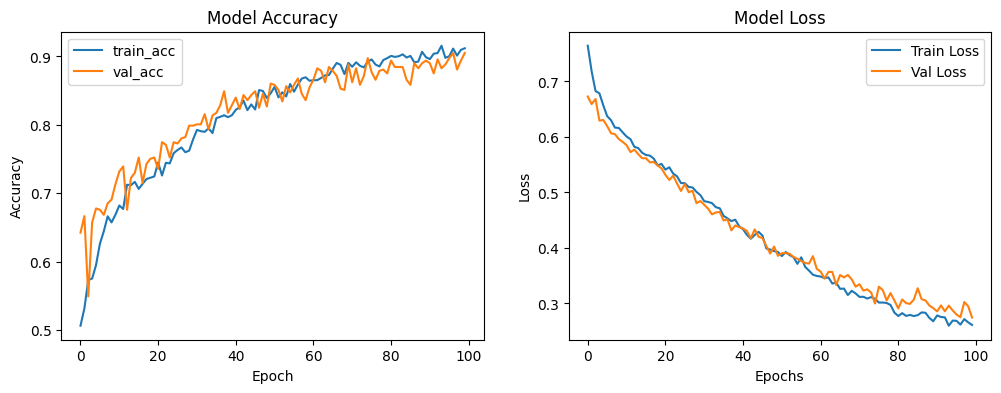

In [ ]:
# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 407ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       264
           1       0.49      0.49      0.49       273

    accuracy                           0.48       537
   macro avg       0.48      0.48      0.48       537
weighted avg       0.48      0.48      0.48       537



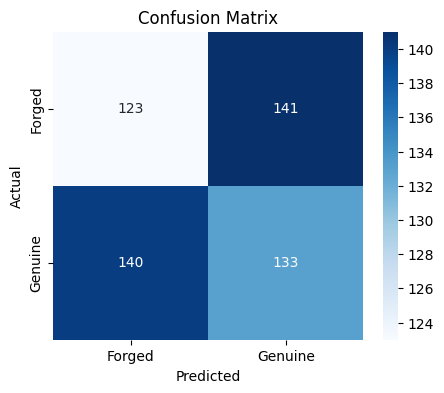

In [ ]:
# Confusion Matrix
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Forged', 'Genuine'], yticklabels=['Forged', 'Genuine'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#Precision, Recall, F1 score
from sklearn.metrics import precision_score, recall_score, f1_score #Import necessary functions

# Convert y_pred to binary predictions (0 or 1) using a threshold (e.g., 0.5)
y_pred_binary = (y_pred > 0.5).astype(int)  # Assuming y_pred contains probabilities

precision = precision_score(y_true, y_pred_binary[:,1], average='binary') # use column one for the genuine predictions
recall = recall_score(y_true, y_pred_binary[:,1], average='binary')
f1 = f1_score(y_true, y_pred_binary[:,1], average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.4854
Recall:    0.4872
F1 Score:  0.4863
